<a href="https://colab.research.google.com/github/immelstorun/Angles-detection-with-YOLO/blob/main/M87_angles_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет!
Команда M87 представляет свое решение задачи по расхождению угла строп.
Мы обучили нейросеть YOLOv8s pose на своем датасете (гпнефть), который подготовили из видеоряда. Разметку keypoints делали в сервисе робофлоу, отттуда же экспортировали датасет для Yolo.

Обучали на 600 эпохах на 15 Гб ГПУ. https://github.com/immelstorun/Angles-detection-with-YOLO

In [ ]:
!nvidia-smi

Thu Apr 25 16:08:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/angles_detector.v4-1.yolov8

/content/gdrive/MyDrive/angles_detector.v4-1.yolov8


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics==8.0.196 -q

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.8/107.7 GB disk)


Now, we can import YOLOv8 into our Notebook:

In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
# !mkdir {HOME}/datasets
# %cd {HOME}/datasets

# !pip install roboflow --quiet

# import roboflow

# roboflow.login()

# rf = roboflow.Roboflow()

# project = rf.workspace("anglesdetector").project("angles_detector")
# dataset = project.version(4).download("yolov8")

## Train a YOLOv8 Keypoint Detection Model


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s-pose.pt')

results = model.train(data=f"/content/gdrive/MyDrive/angles_detector.v4-1.yolov8/data.yaml", epochs=600, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=/content/gdrive/MyDrive/angles_detector.v4-1.yolov8/data.yaml, epochs=600, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=Non

## Test the Keypoint Detection Model

Let's test our keypoint detection model on an image:

In [ ]:
model = YOLO('/content/gdrive/MyDrive/angles_detector.v4-1.yolov8/runs/pose/train/weights/best.pt')

import os
import random



We can visualize our keypoints using the following code:

/content/gdrive/MyDrive/angles_detector.v4-1.yolov8/test/images/124_jpg.rf.48ea44723eaeb389d8182b71ebefcec7.jpg



image 1/1 /content/gdrive/MyDrive/angles_detector.v4-1.yolov8/test/images/124_jpg.rf.48ea44723eaeb389d8182b71ebefcec7.jpg: 640x640 1 container, 701.4ms
Speed: 3.4ms preprocess, 701.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


tensor([[[374.7683,  58.5940],
         [344.7909, 214.0545],
         [400.0717, 226.2337],
         [349.3854, 173.9303],
         [397.1552, 187.0602]]])


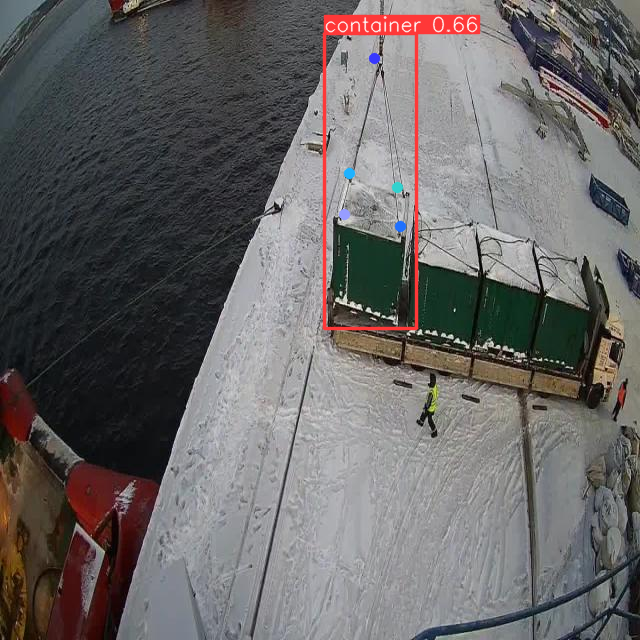

In [ ]:
from PIL import Image

random_file = random.choice(os.listdir(f"/content/gdrive/MyDrive/angles_detector.v4-1.yolov8/test/images"))

image_path = os.path.join("/content/gdrive/MyDrive/angles_detector.v4-1.yolov8/test/images", random_file)

print(image_path)

results = model(image_path)

print(results[0].keypoints.xy)

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

Our model successfully identified keypoints in the image.

## Calculate Keypoint Angle


In [ ]:
results[0].keypoints.xy[0]

tensor([[374.7683,  58.5940],
        [344.7909, 214.0545],
        [400.0717, 226.2337],
        [349.3854, 173.9303],
        [397.1552, 187.0602]])

In [ ]:
# results уже содержат нужный тензор
keypoints = results[0].keypoints.xy[0]

# Переносим тензор на CPU и преобразуем его в список
keypoints_list = keypoints.cpu().numpy().tolist()

# Теперь keypoints_list содержит координаты точек в виде списка списков:
# [
#   [344.5808, 62.5307],
#   [368.8192, 194.1467],
#   ...
# ]
keypoints_list

[[374.768310546875, 58.593963623046875],
 [344.7908935546875, 214.05447387695312],
 [400.07171630859375, 226.23374938964844],
 [349.3854064941406, 173.93026733398438],
 [397.15521240234375, 187.06016540527344]]

In [ ]:
import numpy as np
import math

# Ваш список координат keypoints_list


# 1. Находим вершину (самую верхнюю точку)
vertex = min(keypoints_list, key=lambda x: x[1])

# 2. Находим две основные точки, расположенные по горизонтали
# Отбрасываем вершину из поиска
base_points = [point for point in keypoints_list if point != vertex]

# Находим ближайшие по горизонтали точки к средней точке по оси X
mid_x = sum(point[0] for point in base_points) / len(base_points)
base_points = sorted(base_points, key=lambda x: abs(x[0] - mid_x))

# Берем две ближайшие к средней точке
point1, point2 = base_points[:2]

# 3. Расчет угла между прямыми
def angle_between_points(p1, p2, p3):
    # Векторы p1p2 и p1p3
    p1p2 = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    p1p3 = np.array([p3[0] - p1[0], p3[1] - p1[1]])

    # Скалярное произведение векторов
    dot_product = np.dot(p1p2, p1p3)

    # Длины векторов
    len_p1p2 = np.linalg.norm(p1p2)
    len_p1p3 = np.linalg.norm(p1p3)

    # Угол между векторами в радианах
    angle = math.acos(dot_product / (len_p1p2 * len_p1p3))

    # Угол в градусах
    angle_degrees = math.degrees(angle)

    return angle_degrees

# Рассчитываем угол
angle = angle_between_points(vertex, point1, point2)

print(f"The angle between the lines is: {angle} degrees")

The angle between the lines is: 22.296910278333687 degrees


Triangle not found


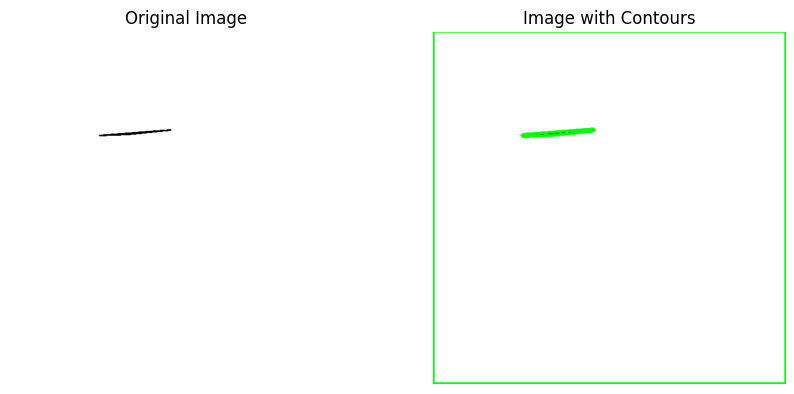

In [ ]:
# Весь хакатон начинался с этого прототипа:)

import cv2
import numpy as np
from matplotlib import pyplot as plt

def angle_between_points(p0, p1, p2):
    a = np.array(p0) - np.array(p1)
    b = np.array(p2) - np.array(p1)
    cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Set a random seed for reproducibility
#np.random.seed(5)

# Create a white image
width, height = 640, 640
image = np.ones((height, width, 3), dtype=np.uint8) * 255

# Generate coordinates for a random triangle
vertices = np.random.randint(100, 300, size=(3, 2))

# Draw the triangle
cv2.polylines(image, [vertices], isClosed=True, color=(0, 0, 0), thickness=2)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, threshold_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

# Find the triangle among contours and calculate the top angle
for contour in contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    if len(approx) == 3:
        vertices = approx.reshape(-1, 2)
        vertices = vertices[np.argsort(vertices[:, 1])]

        top_angle = angle_between_points(vertices[1], vertices[0], vertices[2])
        print(f"Top vertex angle of the triangle: {top_angle:.2f} degrees")
        break
else:
    print("Triangle not found")

# Convert BGR images to RGB for displaying in matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

# Display the images side by side using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axs[0].imshow(image_rgb)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the image with contours
axs[1].imshow(contour_image_rgb)
axs[1].set_title('Image with Contours')
axs[1].axis('off')

plt.show()